[0.96987826 0.68394357 0.3191972 ]
Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]
Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]
[251. 215. 153.]


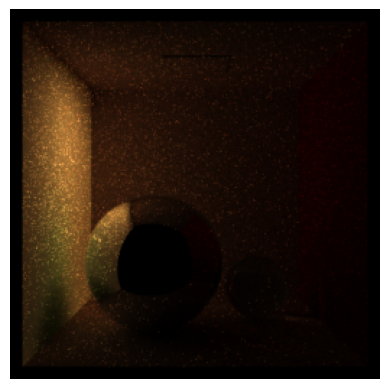

In [18]:
import drjit as dr
import mitsuba as mi

import numpy as np

mi.set_variant('cuda_ad_rgb')

scene = mi.load_file('scenes/cbox.xml', integrator='prb')

params = mi.traverse(scene)

key = 'green.reflectance.value'

# Mark the green wall color parameter as differentiable
dr.enable_grad(params[key])

# Propagate this change to the scene internal state
params.update()

image = mi.render(scene, params, spp=128)

# Forward-propagate gradients through the computation graph
dr.forward(params[key])

# Fetch the image gradient values
grad_image = dr.grad(image)

import matplotlib.pyplot as plt
plt.imshow(grad_image * 1.0)
# plt.imsave('grad.png', grad_image)
plt.axis('off')

grad_image_np = grad_image.numpy()
f = open('output.txt', 'w')
# for k in range(3):
#     for i in range(256):
#         print(f'grad_image[{i}, :, {k}]', file=f)
#         print(grad_image_np[i, :, k], file=f)
for i in range(256):
    print(f'grad_image[{i}]', file=f)
    print(grad_image_np[i], file=f)

# print(np.max(grad_image))
# print(np.argmax(grad_image))
# print(grad_image.shape)

print(grad_image.numpy()[107][34])

image = np.zeros((256, 256, 3))
for i in range(256):
    for j in range(256):
        image[i][j] = [0.96987814, 0.6839436, 0.3191972]
plt.imsave('tmp.png', image)

grad_image = mi.Bitmap(grad_image * 1.0)

grad_image.write('grad.exr')

print(grad_image)

grad_image = grad_image.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, True)

print(grad_image)

grad_image = mi.TensorXf(grad_image)
print(grad_image[107][34].numpy())

SceneParameters[
  ------------------------------------------------------------------------------------
  Name                             Flags    Type  Parent
  ------------------------------------------------------------------------------------
  sensor.near_clip                          float PerspectiveCamera
  sensor.far_clip                           float PerspectiveCamera
  sensor.shutter_open                       float PerspectiveCamera
  sensor.shutter_open_time                  float PerspectiveCamera
  sensor.film.size                          ScalarVector2u HDRFilm
  sensor.film.crop_size                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                   ScalarPoint2u HDRFilm
  sensor.x_fov                     ∂, D     Float PerspectiveCamera
  sensor.to_world                  ∂, D     Transform4f PerspectiveCamera
  teapot.bsdf.reflectance.value    ∂        Color3f SRGBReflectanceSpectrum
  teapot.vertex_count                       int   PLYMesh
  te

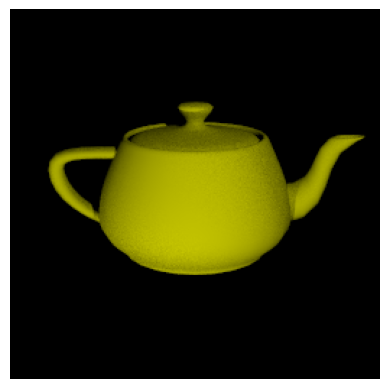

: 

In [21]:
import drjit as dr
import mitsuba as mi

import matplotlib.pyplot as plt

mi.set_variant('cuda_ad_rgb')

scene =  mi.load_file('scenes/simple.xml')
original_image = mi.render(scene, spp=128)

plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2))

params = mi.traverse(scene)
print(params)

params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

params.update()

print(len(params['teapot.vertex_positions']))
V = dr.unravel(mi.Point3f, params['teapot.vertex_positions'])
print(params['teapot.vertex_count'], params['teapot.face_count'])
V.z += 0.5
params['teapot.vertex_positions'] = dr.ravel(V)
params.update()

modified_image = mi.render(scene, spp=128)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1).imshow(original_image)
plt.axis('off')
plt.title('original')
fig.add_subplot(1, 2, 2).imshow(modified_image)
plt.axis('off')
plt.title('modified')

In [59]:
import drjit as dr
import mitsuba as mi

import numpy as np

mi.set_variant('cuda_ad_rgb')

mi.set_log_level(mi.LogLevel.Debug)
dr.set_log_level(dr.LogLevel.Warn)

scene = mi.load_file('scenes/cbox.xml', integrator='prb_npm')

params = mi.traverse(scene)

key = 'green.reflectance.value'

# Mark the green wall color parameter as differentiable
dr.enable_grad(params[key])

# Propagate this change to the scene internal state
params.update()

image = mi.render(scene, params, spp=128)

print(dr.grad(params[key]))

dr.backward(image, dr.ADFlag.ClearVertices)
print(f'backward: {dr.grad(params[key])}')
dr.traverse(type(image), dr.ADMode.Backward)

dr.set_grad(params[key], dr.zeros(type(params[key])))
print(f'zero grad: {dr.grad(params[key])}')

print(type(image))
dr.set_grad(image, dr.ones(type(image)))
print(f'backward_to: {dr.backward_to(params[key])}')

# print(scene.integrator)

[[0.0, 0.0, 0.0]]
backward: [[7572.9619140625, 4088.2705078125, 1715.158447265625]]
zero grad: [[0.0, 0.0, 0.0]]
<class 'drjit.cuda.ad.TensorXf'>
backward_to: [[7572.951171875, 4088.275634765625, 1715.1544189453125]]


In [5]:
import commentjson as json
import tinycudann as tcnn
import torch

with open("../ext/tiny-cuda-nn/data/config_hash.json") as f:
	config = json.load(f)

n_input_dims = 2
n_output_dims = 1

# Option 1: efficient Encoding+Network combo.
model = tcnn.NetworkWithInputEncoding(
	n_input_dims, n_output_dims,
	config["encoding"], config["network"]
)

# Option 2: separate modules. Slower but more flexible.
encoding = tcnn.Encoding(n_input_dims, config["encoding"])
network = tcnn.Network(encoding.n_output_dims, n_output_dims, config["network"])
model = torch.nn.Sequential(encoding, network)